<a href="https://colab.research.google.com/github/mcoudreau/Python/blob/Master/COUDREAU_Manon_1_preparation_nettoyage_analyse_exploratoire_012023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Rappel du contexte**

Lapoule, entreprise française d’agroalimentaire qui souhaite se développer à l'international.

**Objectif :**

L'objectif est de créer des clusters de pays grâce à des caractéristiques connues.

**Mission :**

Notre mission est de sélectionner des groupes de pays pour l'exportation de poulets.
Pour cela, nous allons étudier les régimes alimentaires de chaque pays, notamment en termes de protéines d'origine animale et en termes de calories.

**Variables à étudier :**



*   Évolution de la population sur l'année 2017/2018
*   Proportion de protéines d'origine animale par rapport à la quantité totale de protéines dans la disponibilité alimentaire du pays.
*   Disponibilité alimentaire en protéines par habitant (Disponibilité de protéines en quantité (g/personne/jour))
*   Disponibilité alimentaire en calories par habitant (Disponibilité alimentaire (Kcal/personne/jour))
*   Stabilité politique dans le pays





# **1 Preliminary**

In [51]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import seaborn as sns


from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.pyplot import figure
import plotly.express as px
from sklearn import preprocessing
from sklearn import decomposition
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn import cluster, metrics

In [52]:
%%bash
wget https://drive.google.com/drive/folders/13ilDhLJhW1vN4aGeYcTeBhIhJHVgchDy?usp=share_link

--2023-01-30 09:56:26--  https://drive.google.com/drive/folders/13ilDhLJhW1vN4aGeYcTeBhIhJHVgchDy?usp=share_link
Resolving drive.google.com (drive.google.com)... 172.217.204.139, 172.217.204.100, 172.217.204.102, ...
Connecting to drive.google.com (drive.google.com)|172.217.204.139|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&osid=1&continue=https://drive.google.com/drive/folders/13ilDhLJhW1vN4aGeYcTeBhIhJHVgchDy?usp%3Dshare_link&followup=https://drive.google.com/drive/folders/13ilDhLJhW1vN4aGeYcTeBhIhJHVgchDy?usp%3Dshare_link [following]
--2023-01-30 09:56:27--  https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&osid=1&continue=https://drive.google.com/drive/folders/13ilDhLJhW1vN4aGeYcTeBhIhJHVgchDy?usp%3Dshare_link&followup=https://drive.google.com/drive/folders/13ilDhLJhW1vN4aGeYcTeBhIhJHVgchDy?usp%3Dshare_link
Resolving accounts.google.com (accounts.google.com)

# **2 Data Preparation**

# **a) Croissance population 2017-2018**

In [53]:
pop = pd.read_csv('P5/Population_2000_2018.csv')

In [54]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            4411 non-null   object 
 1   Domaine                 4411 non-null   object 
 2   Code zone               4411 non-null   int64  
 3   Zone                    4411 non-null   object 
 4   Code Élément            4411 non-null   int64  
 5   Élément                 4411 non-null   object 
 6   Code Produit            4411 non-null   int64  
 7   Produit                 4411 non-null   object 
 8   Code année              4411 non-null   int64  
 9   Année                   4411 non-null   int64  
 10  Unité                   4411 non-null   object 
 11  Valeur                  4411 non-null   float64
 12  Symbole                 4411 non-null   object 
 13  Description du Symbole  4411 non-null   object 
 14  Note                    258 non-null    

In [55]:
#Selection des colonnes que je souhaite garder
cols=['Zone', 'Valeur', 'Année']
pop = pop[cols]
pop = pop.rename(columns={'Valeur':'Valeur Pop', 'Zone':'Pays'})
pop.head()

,Pays,Valeur Pop,Année
0,Afghanistan,20779.953,2000
1,Afghanistan,21606.988,2001
2,Afghanistan,22600.770,2002
3,Afghanistan,23680.871,2003
4,Afghanistan,24726.684,2004


In [56]:
#Restriction des données sur l'année 2017 puis 2018
population_2017 = pop[pop['Année'] == 2017]
del population_2017['Année']


population_2018 = pop[pop['Année'] == 2018]
del population_2018['Année']

In [57]:
#Jointure des deux années pour avoir un seul DF
population_2017_2018 = pd.merge(population_2017, population_2018, on='Pays')
population_2017_2018

,Pays,Valeur Pop_x,Valeur Pop_y
0,Afghanistan,36296.113,37171.921
1,Afrique du Sud,57009.756,57792.518
2,Albanie,2884.169,2882.740
3,Algérie,41389.189,42228.408
4,Allemagne,82658.409,83124.418
...,...,...,...
231,Venezuela (République bolivarienne du),29402.484,28887.118
232,Viet Nam,94600.648,95545.962
233,Yémen,27834.819,28498.683
234,Zambie,16853.599,17351.708


In [58]:
#Renommage des variables
population_2017_2018.rename(columns={'Valeur Pop_x': 'Population 2017', 
                                'Valeur Pop_y': 'Population 2018'}, inplace=True)

population_2017_2018.head()

,Pays,Population 2017,Population 2018
0,Afghanistan,36296.113,37171.921
1,Afrique du Sud,57009.756,57792.518
2,Albanie,2884.169,2882.740
3,Algérie,41389.189,42228.408
4,Allemagne,82658.409,83124.418


In [59]:
#Intégration d'une nouvelle variable qui calculera le % d'évolution entre 2017 et 2018
population_2017_2018['%Evolution Pop 2017/2018'] = round(((population_2017_2018['Population 2017'] - population_2017_2018['Population 2018']))\
                                           / population_2017_2018['Population 2017'] *100, 2)
population_2017_2018.head()

,Pays,Population 2017,Population 2018,%Evolution Pop 2017/2018
0,Afghanistan,36296.113,37171.921,-2.41
1,Afrique du Sud,57009.756,57792.518,-1.37
2,Albanie,2884.169,2882.740,0.05
3,Algérie,41389.189,42228.408,-2.03
4,Allemagne,82658.409,83124.418,-0.56


In [60]:
#Check des doublons
population_2017_2018.duplicated().sum()

0

In [61]:
population_2017_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236 entries, 0 to 235
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pays                      236 non-null    object 
 1   Population 2017           236 non-null    float64
 2   Population 2018           236 non-null    float64
 3   %Evolution Pop 2017/2018  236 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.2+ KB


# **b) Disponibilité alimentaire**



In [62]:
#Pour calculer la proportion de protéines d'origine animale et végétale.
animal = pd.read_csv("P5/prot_animale.csv")
vegetal = pd.read_csv("P5/prot_vegetale.csv")

In [63]:
#Ajout d'une variable 'Origine' 
vegetal['Origine'] = 'Végétale'
animal['Origine'] = 'Animale'

df_ani_veg = pd.concat([animal, vegetal])
df_ani_veg

,Code Domaine,Domaine,Code Pays,Pays,Code Élément,Élément,Code Produit,Produit,Code Année,Année,Unité,Valeur,Symbole,Description du Symbole,Origine
0,FBS,Bilans Alimentaires,2,Afghanistan,664,Disponibilité alimentaire (Kcal/personne/jour),2941,Produits Animaux,2013,2013,Kcal/personne/jour,216.00,Fc,Donnée calculée,Animale
1,FBS,Bilans Alimentaires,2,Afghanistan,674,Disponibilité de protéines en quantité (g/pers...,2941,Produits Animaux,2013,2013,g/personne/jour,12.22,Fc,Donnée calculée,Animale
2,FBS,Bilans Alimentaires,2,Afghanistan,684,Disponibilité de matière grasse en quantité (g...,2941,Produits Animaux,2013,2013,g/personne/jour,15.24,Fc,Donnée calculée,Animale
3,FBS,Bilans Alimentaires,2,Afghanistan,5511,Production,2731,Viande de Bovins,2013,2013,Milliers de tonnes,134.00,S,Données standardisées,Animale
4,FBS,Bilans Alimentaires,2,Afghanistan,5611,Importations - Quantité,2731,Viande de Bovins,2013,2013,Milliers de tonnes,6.00,S,Données standardisées,Animale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102710,FBS,Bilans Alimentaires,351,Chine,674,Disponibilité de protéines en quantité (g/pers...,2680,Aliments pour enfants,2013,2013,g/personne/jour,0.04,Fc,Donnée calculée,Végétale
102711,FBS,Bilans Alimentaires,351,Chine,684,Disponibilité de matière grasse en quantité (g...,2680,Aliments pour enfants,2013,2013,g/personne/jour,0.01,Fc,Donnée calculée,Végétale
102712,FBS,Bilans Alimentaires,351,Chine,664,Disponibilité alimentaire (Kcal/personne/jour),2899,Miscellanees,2013,2013,Kcal/personne/jour,0.00,Fc,Donnée calculée,Végétale
102713,FBS,Bilans Alimentaires,351,Chine,674,Disponibilité de protéines en quantité (g/pers...,2899,Miscellanees,2013,2013,g/personne/jour,0.01,Fc,Donnée calculée,Végétale


In [64]:
#Selection des colonnes que je souhaite garder
cols=['Pays', 'Produit', 'Élément', 'Valeur', 'Origine']
dispo_alimentaire = df_ani_veg[cols]
dispo_alimentaire

,Pays,Produit,Élément,Valeur,Origine
0,Afghanistan,Produits Animaux,Disponibilité alimentaire (Kcal/personne/jour),216.00,Animale
1,Afghanistan,Produits Animaux,Disponibilité de protéines en quantité (g/pers...,12.22,Animale
2,Afghanistan,Produits Animaux,Disponibilité de matière grasse en quantité (g...,15.24,Animale
3,Afghanistan,Viande de Bovins,Production,134.00,Animale
4,Afghanistan,Viande de Bovins,Importations - Quantité,6.00,Animale
...,...,...,...,...,...
102710,Chine,Aliments pour enfants,Disponibilité de protéines en quantité (g/pers...,0.04,Végétale
102711,Chine,Aliments pour enfants,Disponibilité de matière grasse en quantité (g...,0.01,Végétale
102712,Chine,Miscellanees,Disponibilité alimentaire (Kcal/personne/jour),0.00,Végétale
102713,Chine,Miscellanees,Disponibilité de protéines en quantité (g/pers...,0.01,Végétale


In [65]:
#Selection des lignes que je souhaite garder
selection_Volaille = ['Viande de Volailles', 'Viandes, Autre', 'Légumineuses Autres et produits']
selection_infos = ['Production','Disponibilité intérieure', 'Disponibilité de protéines en quantité (g/personne/jour)','Disponibilité alimentaire (Kcal/personne/jour)', 'Origine']

dispo_alimentaire_VF = dispo_alimentaire[(dispo_alimentaire['Produit'].isin(selection_Volaille)) & 
                                          dispo_alimentaire['Élément'].isin(selection_infos)]
dispo_alimentaire_VF.head()  

,Pays,Produit,Élément,Valeur,Origine
18,Afghanistan,Viande de Volailles,Production,26.00,Animale
20,Afghanistan,Viande de Volailles,Disponibilité intérieure,75.00,Animale
23,Afghanistan,Viande de Volailles,Disponibilité alimentaire (Kcal/personne/jour),9.00,Animale
24,Afghanistan,Viande de Volailles,Disponibilité de protéines en quantité (g/pers...,0.87,Animale
127,Afrique du Sud,Viande de Volailles,Production,1679.00,Animale


In [66]:
#Méthode .pivot_table() utile pour rendre le dataframe exploitable
dispo_pivot = dispo_alimentaire_VF.pivot_table(index=['Pays', 'Origine'], 
                                            columns='Élément', values='Valeur', aggfunc=sum).reset_index()
dispo_pivot.head()

Élément,Pays,Origine,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Production
0,Afghanistan,Animale,9.0,0.87,75.0,26.0
1,Afrique du Sud,Animale,151.0,14.85,1983.0,1679.0
2,Albanie,Animale,67.0,4.94,42.0,17.0
3,Algérie,Animale,26.0,2.28,291.0,288.0
4,Allemagne,Animale,65.0,7.26,1569.0,1457.0


In [67]:
dispo_pivot.info()
#dispoalim.rename(columns={"Zone": "Pays"}, inplace=True)
#dispoalim.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 6 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Pays                                                      171 non-null    object 
 1   Origine                                                   171 non-null    object 
 2   Disponibilité alimentaire (Kcal/personne/jour)            171 non-null    float64
 3   Disponibilité de protéines en quantité (g/personne/jour)  171 non-null    float64
 4   Disponibilité intérieure                                  171 non-null    float64
 5   Production                                                169 non-null    float64
dtypes: float64(4), object(2)
memory usage: 8.1+ KB


# **c) Stabilité politique - Données de la sécurité alimentaire**

In [68]:
Stab = pd.read_csv("P5/FAOSTAT_data_fr_12-30-2022.csv")

In [69]:
Stab.head()

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,FS,Données de la sécurité alimentaire,4,Afghanistan,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2000,2000,indice,-2.44,X,Ciffre de sources internationales,NaN
1,FS,Données de la sécurité alimentaire,4,Afghanistan,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2002,2002,indice,-2.04,X,Ciffre de sources internationales,NaN
2,FS,Données de la sécurité alimentaire,4,Afghanistan,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2003,2003,indice,-2.20,X,Ciffre de sources internationales,NaN
3,FS,Données de la sécurité alimentaire,4,Afghanistan,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2004,2004,indice,-2.30,X,Ciffre de sources internationales,NaN
4,FS,Données de la sécurité alimentaire,4,Afghanistan,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2005,2005,indice,-2.07,X,Ciffre de sources internationales,NaN


In [70]:
Stab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3908 entries, 0 to 3907
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            3908 non-null   object 
 1   Domaine                 3908 non-null   object 
 2   Code zone (M49)         3908 non-null   int64  
 3   Zone                    3908 non-null   object 
 4   Code Élément            3908 non-null   int64  
 5   Élément                 3908 non-null   object 
 6   Code Produit            3908 non-null   int64  
 7   Produit                 3908 non-null   object 
 8   Code année              3908 non-null   int64  
 9   Année                   3908 non-null   int64  
 10  Unité                   3908 non-null   object 
 11  Valeur                  3908 non-null   float64
 12  Symbole                 3908 non-null   object 
 13  Description du Symbole  3908 non-null   object 
 14  Note                    0 non-null      

In [71]:
#Selection des colonnes que je souhaite garder
cols=['Zone', 'Produit', 'Valeur']
Stab = Stab[cols]
Stab = Stab.rename(columns={'Valeur':'Valeur_Stab', 'Zone' : 'Pays'})
Stab.head()

,Pays,Produit,Valeur_Stab
0,Afghanistan,Stabilité politique et absence de violence/ter...,-2.44
1,Afghanistan,Stabilité politique et absence de violence/ter...,-2.04
2,Afghanistan,Stabilité politique et absence de violence/ter...,-2.20
3,Afghanistan,Stabilité politique et absence de violence/ter...,-2.30
4,Afghanistan,Stabilité politique et absence de violence/ter...,-2.07


In [72]:
Stab_pivot = pd.pivot_table(Stab,columns=['Produit'],
                          index = ['Pays'],
                          values = ['Valeur_Stab'])
Stab_pivot = Stab_pivot.fillna(0)
Stab_pivot.head()

,Valeur_Stab
Produit,Stabilité politique et absence de violence/terrorisme (indice)
Pays,
Afghanistan,-2.4850
Afrique du Sud,-0.1240
Albanie,-0.0635
Algérie,-1.1925
Allemagne,0.8270


In [73]:
Stab_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, Afghanistan to Îles Salomon
Data columns (total 1 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   (Valeur_Stab, Stabilité politique et absence de violence/terrorisme (indice))  199 non-null    float64
dtypes: float64(1)
memory usage: 3.1+ KB


# **d) Import / Export - Matrices du commerce détaillées**

In [74]:
Import_Export = pd.read_csv("P5/Imports_Exports.csv")
Import_Export.head()

,Code Domaine,Domaine,Code pays déclarant (M49),Pays déclarants,Code pays partenaire (M49),Pays partenaires,Code Élément,Élément,Code Produit (CPC),Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,TM,Matrices du commerce détaillées,4,Afghanistan,364,Iran (République islamique d'),5622,Importations - Valeur,2151,Poulets,2017,2017,1000 US$,274,A,Chiffre officiel
1,TM,Matrices du commerce détaillées,4,Afghanistan,586,Pakistan,5622,Importations - Valeur,2151,Poulets,2017,2017,1000 US$,25953,A,Chiffre officiel
2,TM,Matrices du commerce détaillées,710,Afrique du Sud,24,Angola,5922,Exportations - Valeur,2151,Poulets,2017,2017,1000 US$,603,A,Chiffre officiel
3,TM,Matrices du commerce détaillées,710,Afrique du Sud,50,Bangladesh,5922,Exportations - Valeur,2151,Poulets,2017,2017,1000 US$,1,A,Chiffre officiel
4,TM,Matrices du commerce détaillées,710,Afrique du Sud,72,Botswana,5922,Exportations - Valeur,2151,Poulets,2017,2017,1000 US$,1853,A,Chiffre officiel


In [75]:
Import_Export.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1738 entries, 0 to 1737
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Code Domaine                1738 non-null   object
 1   Domaine                     1738 non-null   object
 2   Code pays déclarant (M49)   1738 non-null   int64 
 3   Pays déclarants             1738 non-null   object
 4   Code pays partenaire (M49)  1738 non-null   int64 
 5   Pays partenaires            1738 non-null   object
 6   Code Élément                1738 non-null   int64 
 7   Élément                     1738 non-null   object
 8   Code Produit (CPC)          1738 non-null   int64 
 9   Produit                     1738 non-null   object
 10  Code année                  1738 non-null   int64 
 11  Année                       1738 non-null   int64 
 12  Unité                       1738 non-null   object
 13  Valeur                      1738 non-null   int6

In [76]:
Import_Export.rename(columns={"Pays déclarants": "Pays"}, inplace=True)
Import_Export.head()

,Code Domaine,Domaine,Code pays déclarant (M49),Pays,Code pays partenaire (M49),Pays partenaires,Code Élément,Élément,Code Produit (CPC),Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,TM,Matrices du commerce détaillées,4,Afghanistan,364,Iran (République islamique d'),5622,Importations - Valeur,2151,Poulets,2017,2017,1000 US$,274,A,Chiffre officiel
1,TM,Matrices du commerce détaillées,4,Afghanistan,586,Pakistan,5622,Importations - Valeur,2151,Poulets,2017,2017,1000 US$,25953,A,Chiffre officiel
2,TM,Matrices du commerce détaillées,710,Afrique du Sud,24,Angola,5922,Exportations - Valeur,2151,Poulets,2017,2017,1000 US$,603,A,Chiffre officiel
3,TM,Matrices du commerce détaillées,710,Afrique du Sud,50,Bangladesh,5922,Exportations - Valeur,2151,Poulets,2017,2017,1000 US$,1,A,Chiffre officiel
4,TM,Matrices du commerce détaillées,710,Afrique du Sud,72,Botswana,5922,Exportations - Valeur,2151,Poulets,2017,2017,1000 US$,1853,A,Chiffre officiel


In [77]:
#Selection des colonnes que je souhaite garder
cols=['Pays', 'Élément', 'Produit', 'Valeur']
Exp_Imp = Import_Export[cols]
Exp_Imp = Exp_Imp.rename(columns={'Valeur':'Valeur Imp/Exp'})
Exp_Imp.head()

,Pays,Élément,Produit,Valeur Imp/Exp
0,Afghanistan,Importations - Valeur,Poulets,274
1,Afghanistan,Importations - Valeur,Poulets,25953
2,Afrique du Sud,Exportations - Valeur,Poulets,603
3,Afrique du Sud,Exportations - Valeur,Poulets,1
4,Afrique du Sud,Exportations - Valeur,Poulets,1853


In [78]:
import_export_pivot = pd.pivot_table(Exp_Imp,columns=['Élément', 'Produit'],
                          index = ['Pays'],
                          values = ['Valeur Imp/Exp'])
import_export_pivot = import_export_pivot.fillna(0)
import_export_pivot.head()

Valeur Imp/Exp                      
Élément        Exportations - Valeur Importations - Valeur
Produit                      Poulets               Poulets
Pays                                                      
Afghanistan                  0.00000          13113.500000
Afrique du Sud             499.50000           1848.500000
Albanie                      0.00000           1088.666667
Algérie                      0.00000           4762.750000
Allemagne                11281.37931          13839.928571

In [79]:
import_export_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163 entries, Afghanistan to Îles Féroé
Data columns (total 2 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   (Valeur Imp/Exp, Exportations - Valeur, Poulets)  163 non-null    float64
 1   (Valeur Imp/Exp, Importations - Valeur, Poulets)  163 non-null    float64
dtypes: float64(2)
memory usage: 3.8+ KB


# **3 Merge**

In [80]:
df_1 = dispo_pivot.merge(population_2017_2018, on='Pays')
df_1.head()

,Pays,Origine,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018
0,Afghanistan,Animale,9.0,0.87,75.0,26.0,36296.113,37171.921,-2.41
1,Afrique du Sud,Animale,151.0,14.85,1983.0,1679.0,57009.756,57792.518,-1.37
2,Albanie,Animale,67.0,4.94,42.0,17.0,2884.169,2882.740,0.05
3,Algérie,Animale,26.0,2.28,291.0,288.0,41389.189,42228.408,-2.03
4,Allemagne,Animale,65.0,7.26,1569.0,1457.0,82658.409,83124.418,-0.56


In [81]:
df_2 = df_1.merge(Stab_pivot, on='Pays')
df_2.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


,Pays,Origine,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018,"(Valeur_Stab, Stabilité politique et absence de violence/terrorisme (indice))"
0,Afghanistan,Animale,9.0,0.87,75.0,26.0,36296.113,37171.921,-2.41,-2.4850
1,Afrique du Sud,Animale,151.0,14.85,1983.0,1679.0,57009.756,57792.518,-1.37,-0.1240
2,Albanie,Animale,67.0,4.94,42.0,17.0,2884.169,2882.740,0.05,-0.0635
3,Algérie,Animale,26.0,2.28,291.0,288.0,41389.189,42228.408,-2.03,-1.1925
4,Allemagne,Animale,65.0,7.26,1569.0,1457.0,82658.409,83124.418,-0.56,0.8270


In [82]:
df_version = df_2.merge(import_export_pivot, on='Pays')
df_version.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,3 on the right)
  return merge(


,Pays,Origine,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018,"(Valeur_Stab, Stabilité politique et absence de violence/terrorisme (indice))","(Valeur Imp/Exp, Exportations - Valeur, Poulets)","(Valeur Imp/Exp, Importations - Valeur, Poulets)"
0,Afghanistan,Animale,9.0,0.87,75.0,26.0,36296.113,37171.921,-2.41,-2.4850,0.00000,13113.500000
1,Afrique du Sud,Animale,151.0,14.85,1983.0,1679.0,57009.756,57792.518,-1.37,-0.1240,499.50000,1848.500000
2,Albanie,Animale,67.0,4.94,42.0,17.0,2884.169,2882.740,0.05,-0.0635,0.00000,1088.666667
3,Algérie,Animale,26.0,2.28,291.0,288.0,41389.189,42228.408,-2.03,-1.1925,0.00000,4762.750000
4,Allemagne,Animale,65.0,7.26,1569.0,1457.0,82658.409,83124.418,-0.56,0.8270,11281.37931,13839.928571


In [83]:
df_version.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 0 to 140
Data columns (total 12 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   Pays                                                                           141 non-null    object 
 1   Origine                                                                        141 non-null    object 
 2   Disponibilité alimentaire (Kcal/personne/jour)                                 141 non-null    float64
 3   Disponibilité de protéines en quantité (g/personne/jour)                       141 non-null    float64
 4   Disponibilité intérieure                                                       141 non-null    float64
 5   Production                                                                     140 non-null    float64
 6   Population 2017           

In [84]:
df_version.head()

,Pays,Origine,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018,"(Valeur_Stab, Stabilité politique et absence de violence/terrorisme (indice))","(Valeur Imp/Exp, Exportations - Valeur, Poulets)","(Valeur Imp/Exp, Importations - Valeur, Poulets)"
0,Afghanistan,Animale,9.0,0.87,75.0,26.0,36296.113,37171.921,-2.41,-2.4850,0.00000,13113.500000
1,Afrique du Sud,Animale,151.0,14.85,1983.0,1679.0,57009.756,57792.518,-1.37,-0.1240,499.50000,1848.500000
2,Albanie,Animale,67.0,4.94,42.0,17.0,2884.169,2882.740,0.05,-0.0635,0.00000,1088.666667
3,Algérie,Animale,26.0,2.28,291.0,288.0,41389.189,42228.408,-2.03,-1.1925,0.00000,4762.750000
4,Allemagne,Animale,65.0,7.26,1569.0,1457.0,82658.409,83124.418,-0.56,0.8270,11281.37931,13839.928571


In [85]:
df_version.columns

Index([                                                                           'Pays',
                                                                               'Origine',
                                        'Disponibilité alimentaire (Kcal/personne/jour)',
                              'Disponibilité de protéines en quantité (g/personne/jour)',
                                                              'Disponibilité intérieure',
                                                                            'Production',
                                                                       'Population 2017',
                                                                       'Population 2018',
                                                              '%Evolution Pop 2017/2018',
       ('Valeur_Stab', 'Stabilité politique et absence de violence/terrorisme (indice)'),
                                  ('Valeur Imp/Exp', 'Exportations - Valeur', 'Poulets'),
          

In [86]:
df_principal = df_version.rename(columns = {'Disponibilité alimentaire (Kcal/personne/jour)':'Dispo_alim (Kcal/personne/jour)',
                              'Disponibilité de protéines en quantité (g/personne/jour)':'Dispo_prot_quantité (g/personne/jour)',
                            ('Valeur_Stab', 'Stabilité politique et absence de violence/terrorisme (indice)'):'Stabilite_Politique',
                             ('Valeur Imp/Exp', 'Exportations - Valeur', 'Poulets'):'Exportations Poulets',
                             ('Valeur Imp/Exp', 'Importations - Valeur', 'Poulets'):'Importations Poulets',
                        })

In [87]:
df_principal.columns

Index(['Pays', 'Origine', 'Dispo_alim (Kcal/personne/jour)',
       'Dispo_prot_quantité (g/personne/jour)', 'Disponibilité intérieure',
       'Production', 'Population 2017', 'Population 2018',
       '%Evolution Pop 2017/2018', 'Stabilite_Politique',
       'Exportations Poulets', 'Importations Poulets'],
      dtype='object')

In [88]:
df_principal

,Pays,Origine,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets
0,Afghanistan,Animale,9.0,0.87,75.0,26.0,36296.113,37171.921,-2.41,-2.4850,0.000000,13113.500000
1,Afrique du Sud,Animale,151.0,14.85,1983.0,1679.0,57009.756,57792.518,-1.37,-0.1240,499.500000,1848.500000
2,Albanie,Animale,67.0,4.94,42.0,17.0,2884.169,2882.740,0.05,-0.0635,0.000000,1088.666667
3,Algérie,Animale,26.0,2.28,291.0,288.0,41389.189,42228.408,-2.03,-1.1925,0.000000,4762.750000
4,Allemagne,Animale,65.0,7.26,1569.0,1457.0,82658.409,83124.418,-0.56,0.8270,11281.379310,13839.928571
...,...,...,...,...,...,...,...,...,...,...,...,...
136,Égypte,Animale,56.0,5.04,1184.0,1060.0,96442.591,98423.598,-2.05,-0.9935,5.000000,832.285714
137,Émirats arabes unis,Animale,138.0,13.85,384.0,45.0,9487.203,9630.959,-1.52,0.8135,101.100000,153.000000
138,Équateur,Animale,94.0,6.96,344.0,342.0,16785.361,17084.358,-1.78,-0.5005,0.000000,5468.333333
139,États-Unis d'Amérique,Animale,197.0,17.94,16100.0,20085.0,325084.756,327096.265,-0.62,0.3925,3066.290323,4289.500000


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


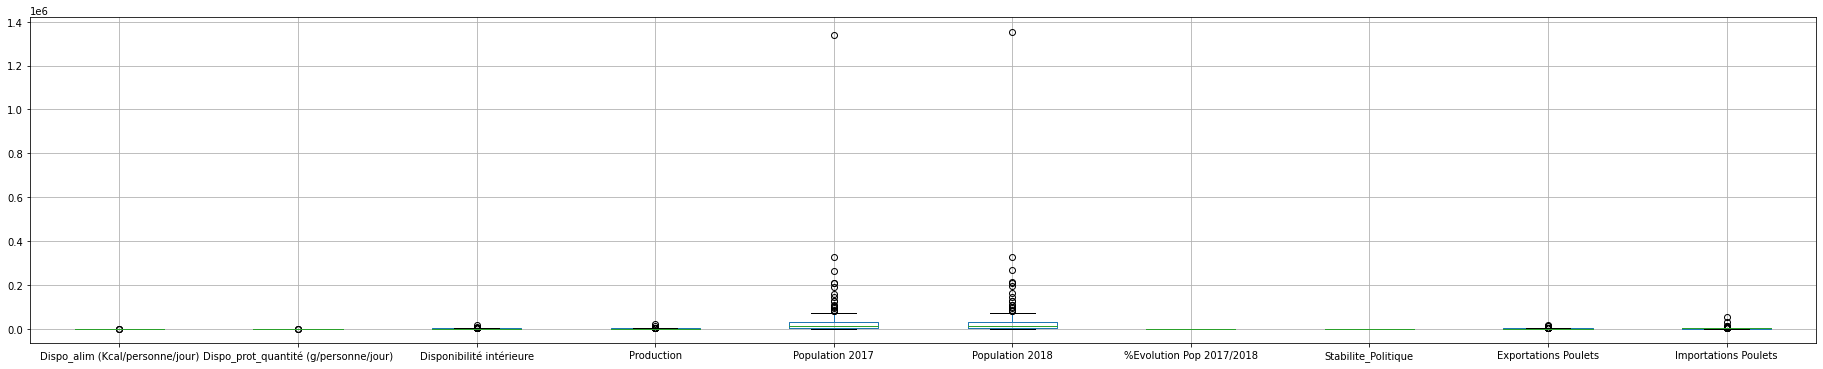

In [89]:
fig, ax = plt.subplots(figsize=(32,6))
df_principal.boxplot()

# **4 Quick tour**

In [90]:
df_principal.head()

,Pays,Origine,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets
0,Afghanistan,Animale,9.0,0.87,75.0,26.0,36296.113,37171.921,-2.41,-2.4850,0.00000,13113.500000
1,Afrique du Sud,Animale,151.0,14.85,1983.0,1679.0,57009.756,57792.518,-1.37,-0.1240,499.50000,1848.500000
2,Albanie,Animale,67.0,4.94,42.0,17.0,2884.169,2882.740,0.05,-0.0635,0.00000,1088.666667
3,Algérie,Animale,26.0,2.28,291.0,288.0,41389.189,42228.408,-2.03,-1.1925,0.00000,4762.750000
4,Allemagne,Animale,65.0,7.26,1569.0,1457.0,82658.409,83124.418,-0.56,0.8270,11281.37931,13839.928571


In [91]:
df_principal.tail()

,Pays,Origine,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets
136,Égypte,Animale,56.0,5.04,1184.0,1060.0,96442.591,98423.598,-2.05,-0.9935,5.000000,832.285714
137,Émirats arabes unis,Animale,138.0,13.85,384.0,45.0,9487.203,9630.959,-1.52,0.8135,101.100000,153.000000
138,Équateur,Animale,94.0,6.96,344.0,342.0,16785.361,17084.358,-1.78,-0.5005,0.000000,5468.333333
139,États-Unis d'Amérique,Animale,197.0,17.94,16100.0,20085.0,325084.756,327096.265,-0.62,0.3925,3066.290323,4289.500000
140,Éthiopie,Animale,2.0,0.22,62.0,62.0,106399.924,109224.414,-2.65,-1.5035,0.000000,45.000000


In [92]:
df_principal.shape

(141, 12)

In [93]:
df_principal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 0 to 140
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Pays                                   141 non-null    object 
 1   Origine                                141 non-null    object 
 2   Dispo_alim (Kcal/personne/jour)        141 non-null    float64
 3   Dispo_prot_quantité (g/personne/jour)  141 non-null    float64
 4   Disponibilité intérieure               141 non-null    float64
 5   Production                             140 non-null    float64
 6   Population 2017                        141 non-null    float64
 7   Population 2018                        141 non-null    float64
 8   %Evolution Pop 2017/2018               141 non-null    float64
 9   Stabilite_Politique                    141 non-null    float64
 10  Exportations Poulets                   141 non-null    float64
 11  Import

In [94]:
#Quel est le % de valeurs manquantes par colonne ?
df_principal.isna().mean()

Pays                                     0.000000
Origine                                  0.000000
Dispo_alim (Kcal/personne/jour)          0.000000
Dispo_prot_quantité (g/personne/jour)    0.000000
Disponibilité intérieure                 0.000000
Production                               0.007092
Population 2017                          0.000000
Population 2018                          0.000000
%Evolution Pop 2017/2018                 0.000000
Stabilite_Politique                      0.000000
Exportations Poulets                     0.000000
Importations Poulets                     0.000000
dtype: float64

In [95]:
df_principal.duplicated().sum()

0

In [96]:
#Combien y a-t-il de valeurs différentes par colonne ?
df_principal.nunique()

Pays                                     141
Origine                                    1
Dispo_alim (Kcal/personne/jour)           96
Dispo_prot_quantité (g/personne/jour)    131
Disponibilité intérieure                 120
Production                               108
Population 2017                          141
Population 2018                          141
%Evolution Pop 2017/2018                 118
Stabilite_Politique                      137
Exportations Poulets                      87
Importations Poulets                     137
dtype: int64

In [97]:
#describe nous donne une idée de la dispersion globale de nos données :
describe = df_principal.describe()
describe

,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets
count,141.000000,141.000000,141.000000,140.000000,1.410000e+02,1.410000e+02,141.000000,141.000000,141.000000,141.000000
mean,77.801418,7.397163,582.418440,613.571429,3.904204e+04,3.950987e+04,-1.180993,-0.026053,785.027109,2066.565409
std,61.796234,5.584672,1650.573637,2067.401108,1.216686e+05,1.229527e+05,1.135118,0.859025,1988.997237,5367.756490
min,2.000000,0.160000,2.000000,0.000000,5.204500e+01,5.244100e+01,-3.890000,-2.485000,0.000000,0.000000
25%,26.000000,2.690000,37.000000,18.000000,2.944791e+03,2.951745e+03,-1.970000,-0.687000,0.000000,159.600000
50%,65.000000,6.820000,105.000000,88.500000,9.785843e+03,9.949537e+03,-1.060000,0.042000,42.000000,693.000000
75%,105.000000,10.640000,366.000000,393.000000,3.144430e+04,3.198926e+04,-0.320000,0.753000,722.000000,1713.923077
max,293.000000,25.780000,16100.000000,20085.000000,1.338677e+06,1.352642e+06,1.750000,1.407000,14318.500000,51884.250000


In [98]:
# Afficher la matrice de corrélation
df_correlation = df_principal.corr()
df_correlation.head()

,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets
Dispo_alim (Kcal/personne/jour),1.000000,0.972006,0.249818,0.245608,-0.110690,-0.111916,0.347163,0.418682,0.125993,-0.036224
Dispo_prot_quantité (g/personne/jour),0.972006,1.000000,0.228501,0.219691,-0.123575,-0.124899,0.372227,0.448406,0.144325,-0.016583
Disponibilité intérieure,0.249818,0.228501,1.000000,0.987067,0.392142,0.390737,0.112944,-0.051854,0.221246,0.067498
Production,0.245608,0.219691,0.987067,1.000000,0.359933,0.358616,0.102370,-0.033208,0.220947,0.076137
Population 2017,-0.110690,-0.123575,0.392142,0.359933,1.000000,0.999992,-0.004791,-0.247021,0.029781,0.008011


Text(0.5, 1.0, 'Corrélation entre les différentes variables')

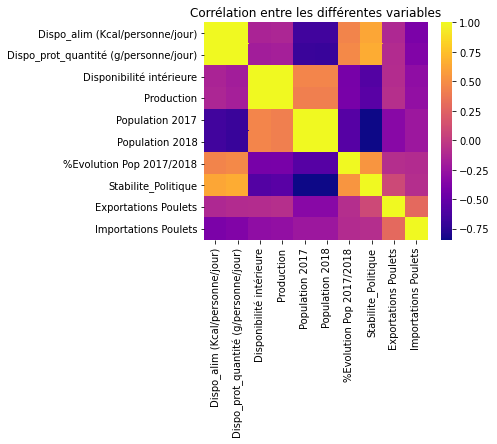

In [99]:
# Heatmap de corrélations entre les différentes variables
plt.figure(figsize=(5, 4))
sns.heatmap(df_correlation.corr(),cmap='plasma')
plt.title('Corrélation entre les différentes variables')

**VERIFICATION DE LA DISTRIBUTION DES VARIABLES DE TOUS LES INDIVIDUS**

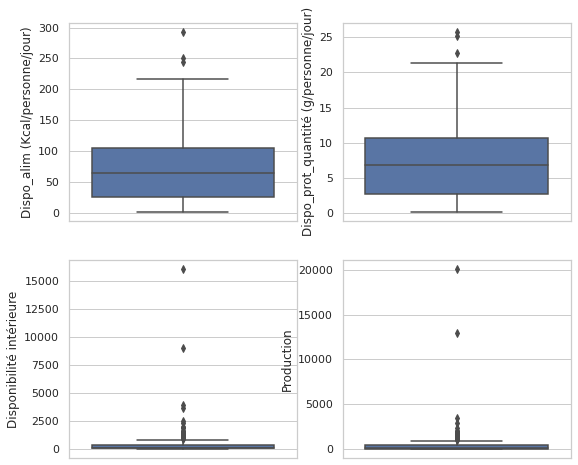

In [100]:
# Afficher des boxplot
plt.figure(figsize=(9, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=df_principal,y='Dispo_alim (Kcal/personne/jour)')
plt.subplot(222)
sns.boxplot(data=df_principal, y='Dispo_prot_quantité (g/personne/jour)')
plt.subplot(223)
sns.boxplot(data=df_principal, y='Disponibilité intérieure')
plt.subplot(224)
sns.boxplot(data=df_principal,y='Production')

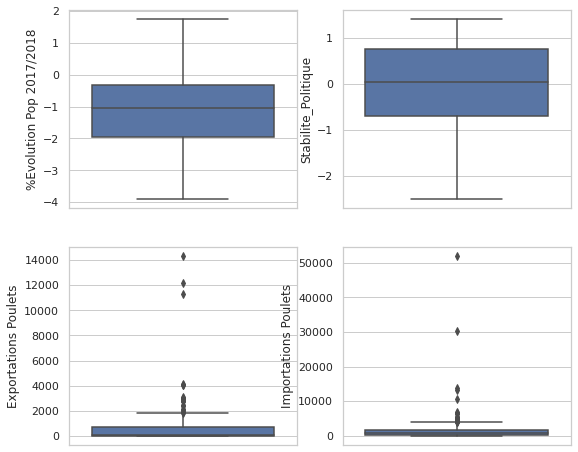

In [101]:
plt.figure(figsize=(9, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=df_principal,y='%Evolution Pop 2017/2018')
plt.subplot(222)
sns.boxplot(data=df_principal,y='Stabilite_Politique')
plt.subplot(223)
sns.boxplot(data=df_principal,y='Exportations Poulets')
plt.subplot(224)
sns.boxplot(data=df_principal,y='Importations Poulets')

In [102]:
# Afficher les valeurs extremes de la Disponibilité intérieure
df_principal.sort_values(by = ['Disponibilité intérieure'], ascending = False).head()

,Pays,Origine,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets
139,États-Unis d'Amérique,Animale,197.0,17.94,16100.0,20085.0,325084.756,327096.265,-0.62,0.3925,3066.290323,4289.500000
21,Brésil,Animale,192.0,14.56,9016.0,12915.0,207833.823,209469.323,-0.79,-0.1975,4116.411765,475.000000
46,Fédération de Russie,Animale,92.0,9.27,3957.0,3457.0,145530.082,145734.038,-0.14,-0.9230,1322.700000,2843.800000
85,Mexique,Animale,114.0,8.58,3685.0,2846.0,124777.324,126190.788,-1.13,-0.6045,0.000000,4306.333333
65,Japon,Animale,64.0,6.95,2506.0,1459.0,127502.725,127202.192,0.24,1.0300,7.000000,1180.166667


In [103]:
# Afficher les valeurs extremes de la production 
df_principal.sort_values(by = ['Production'], ascending = False).head()

,Pays,Origine,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets
139,États-Unis d'Amérique,Animale,197.0,17.94,16100.0,20085.0,325084.756,327096.265,-0.62,0.3925,3066.290323,4289.500000
21,Brésil,Animale,192.0,14.56,9016.0,12915.0,207833.823,209469.323,-0.79,-0.1975,4116.411765,475.000000
46,Fédération de Russie,Animale,92.0,9.27,3957.0,3457.0,145530.082,145734.038,-0.14,-0.9230,1322.700000,2843.800000
85,Mexique,Animale,114.0,8.58,3685.0,2846.0,124777.324,126190.788,-1.13,-0.6045,0.000000,4306.333333
58,Inde,Animale,6.0,0.63,2352.0,2358.0,1338676.785,1352642.280,-1.04,-1.1045,50.333333,646.500000


In [104]:
# Afficher les valeurs extremes de l'Importations Poulets
df_principal.sort_values(by = ['Importations Poulets'], ascending = False).head()

,Pays,Origine,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets
15,Belgique,Animale,43.0,4.36,143.0,389.0,11419.748,11482.178,-0.55,0.7530,2791.325581,51884.250000
100,Pays-Bas,Animale,82.0,9.90,432.0,998.0,17021.347,17059.560,-0.22,1.0235,4011.612903,30302.076923
4,Allemagne,Animale,65.0,7.26,1569.0,1457.0,82658.409,83124.418,-0.56,0.8270,11281.379310,13839.928571
0,Afghanistan,Animale,9.0,0.87,75.0,26.0,36296.113,37171.921,-2.41,-2.4850,0.000000,13113.500000
29,Canada,Animale,145.0,13.08,1290.0,1254.0,36732.095,37074.562,-0.93,1.0740,717.037037,10525.400000


In [105]:
# Afficher les valeurs extremes de l'Exportations Poulets
df_principal.sort_values(by = ['Exportations Poulets'], ascending = False).head()

,Pays,Origine,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets
77,Malaisie,Animale,162.0,13.29,1477.0,1458.0,31104.646,31528.033,-1.36,0.2070,14318.500000,1635.100000
61,Irlande,Animale,96.0,10.85,130.0,103.0,4753.279,4818.690,-1.38,1.1080,12208.000000,3097.000000
4,Allemagne,Animale,65.0,7.26,1569.0,1457.0,82658.409,83124.418,-0.56,0.8270,11281.379310,13839.928571
21,Brésil,Animale,192.0,14.56,9016.0,12915.0,207833.823,209469.323,-0.79,-0.1975,4116.411765,475.000000
116,Slovaquie,Animale,53.0,5.14,86.0,64.0,5447.900,5453.014,-0.09,0.8840,4042.333333,4132.375000


# **5 Classification Ascendante Hiérarchique (CAH) : Le dendrogramme**

In [106]:
cols = ['Pays',"Dispo_alim (Kcal/personne/jour)","Dispo_prot_quantité (g/personne/jour)","%Evolution Pop 2017/2018","Stabilite_Politique","Exportations Poulets", "Importations Poulets"]

In [107]:
df_principal_filtre = df_principal[cols]

In [108]:
df_principal_filtre

,Pays,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets
0,Afghanistan,9.0,0.87,-2.41,-2.4850,0.000000,13113.500000
1,Afrique du Sud,151.0,14.85,-1.37,-0.1240,499.500000,1848.500000
2,Albanie,67.0,4.94,0.05,-0.0635,0.000000,1088.666667
3,Algérie,26.0,2.28,-2.03,-1.1925,0.000000,4762.750000
4,Allemagne,65.0,7.26,-0.56,0.8270,11281.379310,13839.928571
...,...,...,...,...,...,...,...
136,Égypte,56.0,5.04,-2.05,-0.9935,5.000000,832.285714
137,Émirats arabes unis,138.0,13.85,-1.52,0.8135,101.100000,153.000000
138,Équateur,94.0,6.96,-1.78,-0.5005,0.000000,5468.333333
139,États-Unis d'Amérique,197.0,17.94,-0.62,0.3925,3066.290323,4289.500000


In [109]:
df_principal_CAH = df_principal_filtre.set_index("Pays")
df_principal_CAH.head()

,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets
Pays,,,,,,
Afghanistan,9.0,0.87,-2.41,-2.4850,0.00000,13113.500000
Afrique du Sud,151.0,14.85,-1.37,-0.1240,499.50000,1848.500000
Albanie,67.0,4.94,0.05,-0.0635,0.00000,1088.666667
Algérie,26.0,2.28,-2.03,-1.1925,0.00000,4762.750000
Allemagne,65.0,7.26,-0.56,0.8270,11281.37931,13839.928571


Dendogramme

In [ ]:
Z = linkage(X_scaled, method="ward")
Z[:10]
fig, ax = plt.subplots(1, 1, figsize=(10,40))

_ = dendrogram(Z, ax=ax, labels=df_principal_CAH.index, orientation = "left")

plt.title("Dendogramme")
ax.set_xlabel("Distance")
ax.set_ylabel("Cours")
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

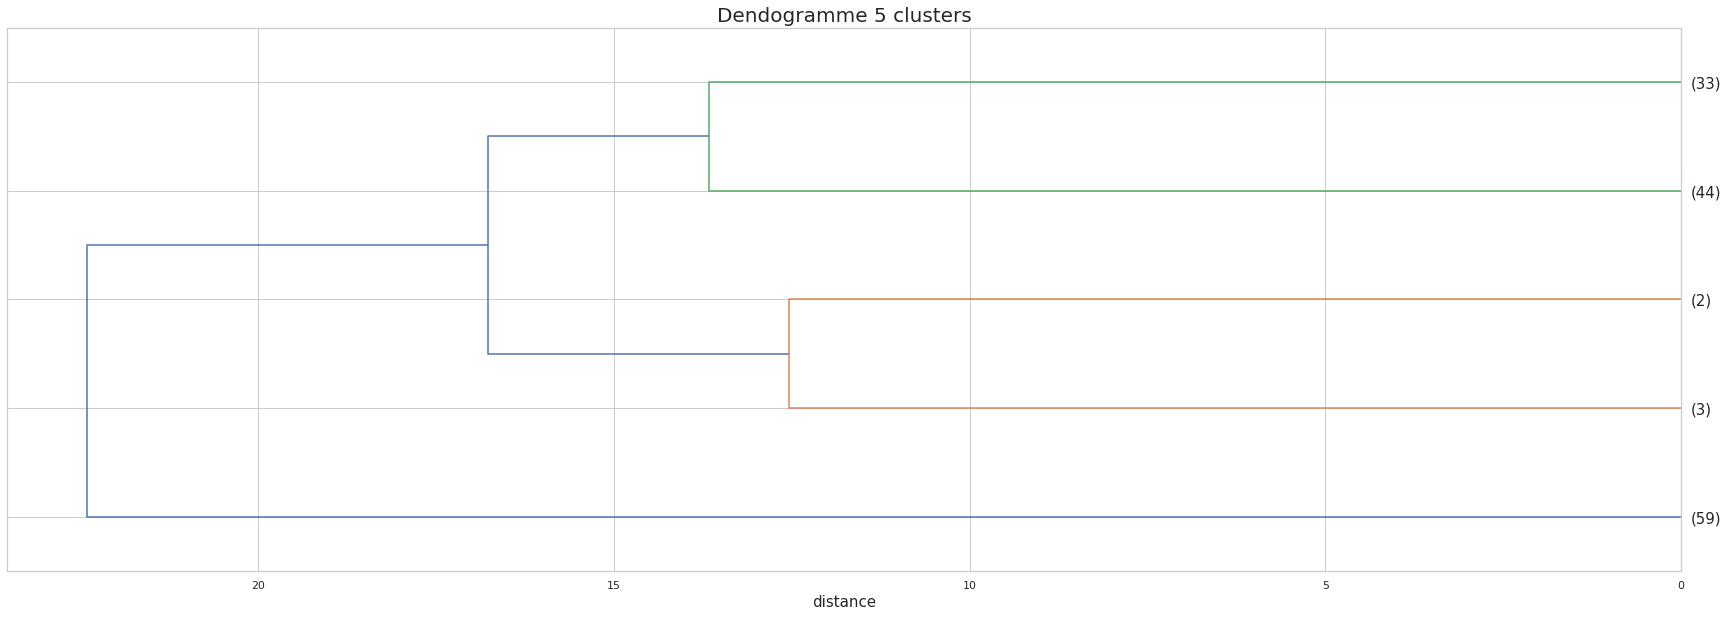

In [117]:
#Coupage du dendrogramme en 5 groupes pour avoir une première idée du partitionnement
fig = plt.figure(figsize=(30,10))
plt.title('Dendogramme 5 clusters', fontsize=20)
plt.xlabel('distance', fontsize=15)

dendrogram(Z, labels = df_principal_CAH.index, p=5, truncate_mode='lastp', leaf_font_size=15, orientation='left')
plt.show()

# **6 Clustering : Kmeans**

1 - Recherche du nombre de clusters

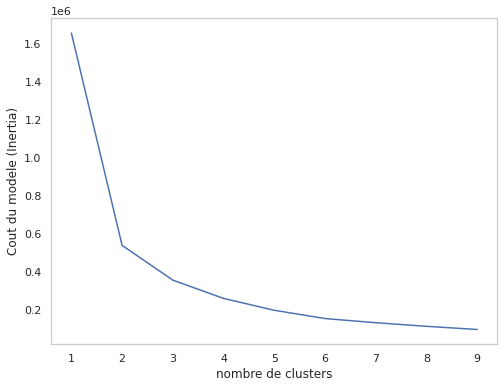

In [118]:
inertia = []
k_range=range(1,10)
for k in k_range:
    model=KMeans(n_clusters=k).fit(Z)
    inertia.append(model.inertia_)
    
fig = plt.figure(figsize=(8,6))
plt.plot(k_range,inertia )
plt.xlabel('nombre de clusters')
plt.ylabel('Cout du modele (Inertia)')
plt.grid()
plt.show()

2- Affichage du nuage de points (individus) en clusters avec les centoîdes

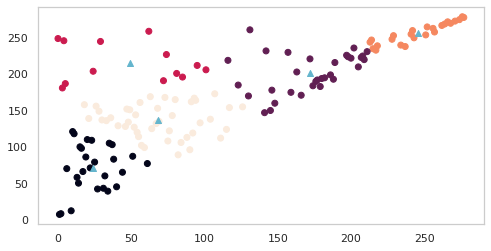

Inertie totale : 200682.23602905392


In [119]:
fig = plt.figure(figsize=(8,4))
model = KMeans(n_clusters=5)
model.fit(Z)
model.predict(Z)
plt.scatter(Z[:,0], Z[:,1],c=model.predict(Z))
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], marker='^',c='c')
plt.grid()
plt.show()
print('Inertie totale :',model.inertia_)

Affichage du coefficient de silhouette

Populating the interactive namespace from numpy and matplotlib


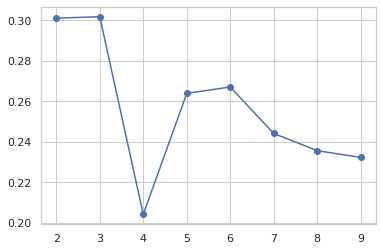

In [139]:
%pylab inline
from sklearn import cluster, metrics

silhouettes = []

for num_clusters in range(2,10):
    cls = cluster.KMeans(n_clusters = num_clusters,
                         n_init=1, init="random")
    cls.fit(X_scaled)
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2,10), silhouettes, marker='o')

a) K-means

In [121]:
#Préparation des données
X = df_principal_CAH.values
#Centrage / réduction des données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [122]:
#On applique ensuite la fonction fclusters de scipypour définir les clusters :
#Identification des 5 groupes obtenus
clusters = fcluster(Z, 5, criterion='maxclust')
clusters

array([1, 5, 4, 1, 2, 5, 5, 5, 4, 5, 4, 1, 5, 1, 5, 3, 5, 5, 4, 1, 5, 5,
       4, 1, 5, 1, 4, 1, 1, 5, 5, 4, 1, 1, 4, 4, 1, 4, 5, 4, 4, 4, 1, 4,
       4, 4, 4, 5, 1, 1, 5, 4, 1, 1, 5, 4, 1, 4, 1, 1, 1, 2, 5, 4, 5, 4,
       5, 4, 1, 1, 5, 4, 1, 4, 4, 4, 1, 2, 1, 1, 1, 4, 1, 5, 1, 5, 1, 4,
       1, 1, 1, 1, 4, 5, 1, 1, 1, 1, 5, 1, 3, 1, 4, 4, 1, 4, 1, 4, 4, 1,
       5, 5, 5, 1, 4, 1, 4, 4, 1, 4, 5, 4, 1, 1, 1, 5, 1, 1, 4, 4, 1, 4,
       4, 1, 1, 1, 1, 5, 1, 5, 1], dtype=int32)

In [123]:
#index triés des groupes
idg = np.argsort(clusters)
#Affichage des pays selon leurs groupes
df = pd.DataFrame(df_principal_CAH.index[idg], clusters[idg]).reset_index()
groupes_clusters = df.rename(columns={'index':'Groupe'})
groupes_clusters.head()

,Groupe,Pays
0,1,Afghanistan
1,1,Niger
2,1,Nicaragua
3,1,Namibie
4,1,Mongolie


In [124]:
groupes_clusters5 = pd.merge(df_principal_CAH, groupes_clusters, on='Pays')
groupes_clusters5.head()

,Pays,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets,Groupe
0,Afghanistan,9.0,0.87,-2.41,-2.4850,0.00000,13113.500000,1
1,Afrique du Sud,151.0,14.85,-1.37,-0.1240,499.50000,1848.500000,5
2,Albanie,67.0,4.94,0.05,-0.0635,0.00000,1088.666667,4
3,Algérie,26.0,2.28,-2.03,-1.1925,0.00000,4762.750000,1
4,Allemagne,65.0,7.26,-0.56,0.8270,11281.37931,13839.928571,2


MOYENNES DES VARIABLES PAR GROUPE

In [125]:
#afficher les moyennes des variables de chaque groupe
groupe=(1,2,3,4,5)
for n in groupe:
    affi=groupes_clusters5.loc[groupes_clusters5['Groupe']==n].mean()
    print(affi)

Dispo_alim (Kcal/personne/jour)            31.169492
Dispo_prot_quantité (g/personne/jour)       3.018644
%Evolution Pop 2017/2018                   -2.104068
Stabilite_Politique                        -0.638644
Exportations Poulets                      212.502107
Importations Poulets                     1313.947491
Groupe                                      1.000000
dtype: float64
Dispo_alim (Kcal/personne/jour)            107.666667
Dispo_prot_quantité (g/personne/jour)       10.466667
%Evolution Pop 2017/2018                    -1.100000
Stabilite_Politique                          0.714000
Exportations Poulets                     12602.626437
Importations Poulets                      6190.676190
Groupe                                       2.000000
dtype: float64
Dispo_alim (Kcal/personne/jour)             62.500000
Dispo_prot_quantité (g/personne/jour)        7.130000
%Evolution Pop 2017/2018                    -0.385000
Stabilite_Politique                          0.888250
Expor

<ipython-input-125-fa1a201e2430>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  affi=groupes_clusters5.loc[groupes_clusters5['Groupe']==n].mean()


In [126]:
groupes_clusters5.mean()

<ipython-input-126-9ec7173fb108>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupes_clusters5.mean()


Dispo_alim (Kcal/personne/jour)            77.801418
Dispo_prot_quantité (g/personne/jour)       7.397163
%Evolution Pop 2017/2018                   -1.180993
Stabilite_Politique                        -0.026053
Exportations Poulets                      785.027109
Importations Poulets                     2066.565409
Groupe                                      2.921986
dtype: float64

In [127]:
# Cluster 1
cluster_1=groupes_clusters5.loc[groupes_clusters5['Groupe']==1]

cluster_1.head()

,Pays,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets,Groupe
0,Afghanistan,9.0,0.87,-2.41,-2.4850,0.0,13113.500000,1
3,Algérie,26.0,2.28,-2.03,-1.1925,0.0,4762.750000,1
11,Azerbaïdjan,35.0,3.56,-1.06,-0.7180,59.0,564.666667,1
13,Bangladesh,6.0,0.44,-1.06,-1.2755,0.0,1713.923077,1
19,Botswana,18.0,1.90,-2.22,1.0285,15.0,1124.333333,1


In [128]:
# Cluster 2
cluster_2=groupes_clusters5.loc[groupes_clusters5['Groupe']==2]
cluster_2.head()

,Pays,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets,Groupe
4,Allemagne,65.0,7.26,-0.56,0.827,11281.37931,13839.928571,2
61,Irlande,96.0,10.85,-1.38,1.108,12208.00000,3097.000000,2
77,Malaisie,162.0,13.29,-1.36,0.207,14318.50000,1635.100000,2


In [129]:
# Cluster 3
cluster_3=groupes_clusters5.loc[groupes_clusters5['Groupe']==3]
cluster_3.head()

,Pays,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets,Groupe
15,Belgique,43.0,4.36,-0.55,0.7530,2791.325581,51884.250000,3
100,Pays-Bas,82.0,9.90,-0.22,1.0235,4011.612903,30302.076923,3


In [130]:
# Cluster 4
cluster_4=groupes_clusters5.loc[groupes_clusters5['Groupe']==4]
cluster_4.head()

,Pays,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets,Groupe
2,Albanie,67.0,4.94,0.05,-0.0635,0.000000,1088.666667,4
8,Arménie,45.0,4.51,-0.24,-0.1880,0.000000,694.833333,4
10,Autriche,66.0,7.67,-0.81,1.1155,1090.583333,4089.125000,4
18,Bosnie-Herzégovine,44.0,4.48,0.82,-0.4400,308.500000,434.166667,4
22,Bulgarie,79.0,8.09,0.72,0.2940,1330.000000,915.400000,4


In [131]:
# Cluster 5
cluster_5=groupes_clusters5.loc[groupes_clusters5['Groupe']==5]
cluster_5.head(10)

,Pays,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets,Groupe
1,Afrique du Sud,151.0,14.85,-1.37,-0.1240,499.500000,1848.500000,5
5,Antigua-et-Barbuda,251.0,19.00,-0.90,0.8775,0.000000,17.500000,5
6,Arabie saoudite,173.0,17.43,-1.82,-0.3930,2149.500000,458.666667,5
7,Argentine,166.0,12.38,-0.97,-0.0665,722.000000,3735.000000,5
9,Australie,186.0,16.06,-1.28,0.9695,918.222222,0.000000,5
12,Bahamas,186.0,15.78,-1.02,0.9420,0.000000,317.000000,5
14,Barbade,180.0,14.19,-0.14,1.0845,74.857143,0.000000,5
16,Belize,121.0,9.13,-1.94,0.1710,0.000000,665.000000,5
17,Bolivie (État plurinational de),148.0,10.91,-1.43,-0.5060,0.000000,2363.500000,5
20,Brunéi Darussalam,214.0,21.36,-1.06,1.1785,0.000000,528.500000,5



Représentation de la distribution des variables par groupe en utilisant une boite à moustache

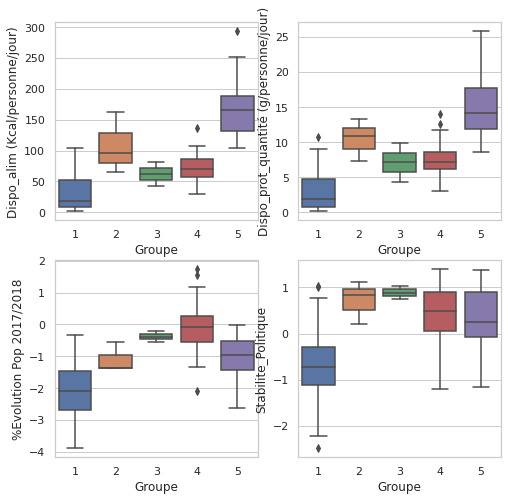

In [132]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=groupes_clusters5, x='Groupe', y='Dispo_alim (Kcal/personne/jour)')
plt.subplot(222)
sns.boxplot(data=groupes_clusters5, x='Groupe', y='Dispo_prot_quantité (g/personne/jour)')
plt.subplot(223)
sns.boxplot(data=groupes_clusters5, x='Groupe', y='%Evolution Pop 2017/2018')
plt.subplot(224)
sns.boxplot(data=groupes_clusters5, x='Groupe', y='Stabilite_Politique')

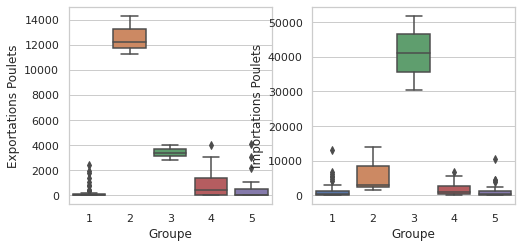

In [133]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=groupes_clusters5, x='Groupe', y='Exportations Poulets')
plt.subplot(222)
sns.boxplot(data=groupes_clusters5, x='Groupe', y='Importations Poulets')

In [134]:
#Index trié des clusters
#idk = np.argsort(clusters_test.labels_)

#Affichage des observations selon leurs clusters
#clusters5 = pd.DataFrame(df_principal_CAH.index[idk], clusters_test.labels_[idk]).reset_index()
#clusters5 = clusters5.rename(columns={'index':'cluster'})

In [135]:
groupes_clusters5_pivot = pd.pivot_table(groupes_clusters5, columns=['Groupe'],
                          values = ['Dispo_alim (Kcal/personne/jour)', 'Dispo_prot_quantité (g/personne/jour)','Stabilite_Politique','%Evolution Pop 2017/2018','Importations Poulets','Exportations Poulets'],
                          aggfunc = np.mean)
groupes_clusters5_pivot = groupes_clusters5_pivot.fillna(0)
groupes_clusters5_pivot.head(19)

Groupe,1,2,3,4,5
%Evolution Pop 2017/2018,-2.104068,-1.100000,-0.385000,-0.097727,-1.030606
Dispo_alim (Kcal/personne/jour),31.169492,107.666667,62.500000,71.863636,167.303030
Dispo_prot_quantité (g/personne/jour),3.018644,10.466667,7.130000,7.432500,14.915455
Exportations Poulets,212.502107,12602.626437,3401.469242,882.492825,445.778665
Importations Poulets,1313.947491,6190.676190,41093.163462,1682.096720,1184.612410
Stabilite_Politique,-0.638644,0.714000,0.888250,0.418330,0.353985


Text(0.5, 1.0, 'Heatmap')

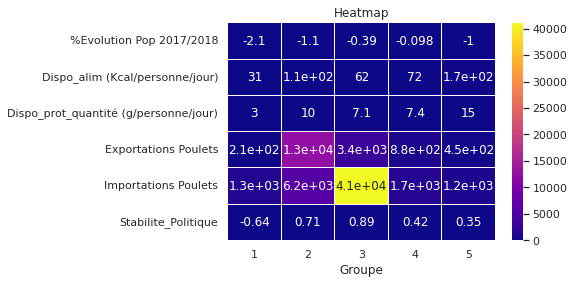

In [136]:
df_heatmap = groupes_clusters5_pivot
sns.heatmap(df_heatmap, annot = True, cmap='plasma', linewidths=0.1)

plt.title('Heatmap')

# **7 Data selection for PCA**

In [140]:
cols = ['Pays',"Dispo_alim (Kcal/personne/jour)","Dispo_prot_quantité (g/personne/jour)","%Evolution Pop 2017/2018","Stabilite_Politique","Exportations Poulets", "Importations Poulets"]

In [141]:
df_PCA = df_principal[cols]
df_PCA.head()

,Pays,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets
0,Afghanistan,9.0,0.87,-2.41,-2.4850,0.00000,13113.500000
1,Afrique du Sud,151.0,14.85,-1.37,-0.1240,499.50000,1848.500000
2,Albanie,67.0,4.94,0.05,-0.0635,0.00000,1088.666667
3,Algérie,26.0,2.28,-2.03,-1.1925,0.00000,4762.750000
4,Allemagne,65.0,7.26,-0.56,0.8270,11281.37931,13839.928571


In [142]:
df_PCA = df_principal.set_index("Pays")
df_PCA.head()

,Origine,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets
Pays,,,,,,,,,,,
Afghanistan,Animale,9.0,0.87,75.0,26.0,36296.113,37171.921,-2.41,-2.4850,0.00000,13113.500000
Afrique du Sud,Animale,151.0,14.85,1983.0,1679.0,57009.756,57792.518,-1.37,-0.1240,499.50000,1848.500000
Albanie,Animale,67.0,4.94,42.0,17.0,2884.169,2882.740,0.05,-0.0635,0.00000,1088.666667
Algérie,Animale,26.0,2.28,291.0,288.0,41389.189,42228.408,-2.03,-1.1925,0.00000,4762.750000
Allemagne,Animale,65.0,7.26,1569.0,1457.0,82658.409,83124.418,-0.56,0.8270,11281.37931,13839.928571


# **8 Data split for PCA**

In [143]:
cols1 = ["Dispo_alim (Kcal/personne/jour)","Dispo_prot_quantité (g/personne/jour)","%Evolution Pop 2017/2018","Stabilite_Politique","Exportations Poulets", "Importations Poulets"]

In [144]:
#Séparons nos données : d'un coté `X_values` la matrice des données (nos valeurs):
X = df_PCA[cols1].values
X[:5]

array([[ 9.00000000e+00,  8.70000000e-01, -2.41000000e+00,
        -2.48500000e+00,  0.00000000e+00,  1.31135000e+04],
       [ 1.51000000e+02,  1.48500000e+01, -1.37000000e+00,
        -1.24000000e-01,  4.99500000e+02,  1.84850000e+03],
       [ 6.70000000e+01,  4.94000000e+00,  5.00000000e-02,
        -6.35000000e-02,  0.00000000e+00,  1.08866667e+03],
       [ 2.60000000e+01,  2.28000000e+00, -2.03000000e+00,
        -1.19250000e+00,  0.00000000e+00,  4.76275000e+03],
       [ 6.50000000e+01,  7.26000000e+00, -5.60000000e-01,
         8.27000000e-01,  1.12813793e+04,  1.38399286e+04]])

In [145]:
#Check np.array 
type(X)

numpy.ndarray

In [146]:
#Nous enregistrons les noms de nos cours dans une variable names :
names = df_PCA.index
names

Index(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne',
       'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine', 'Arménie',
       'Australie',
       ...
       'Venezuela (République bolivarienne du)', 'Viet Nam', 'Yémen', 'Zambie',
       'Zimbabwe', 'Égypte', 'Émirats arabes unis', 'Équateur',
       'États-Unis d'Amérique', 'Éthiopie'],
      dtype='object', name='Pays', length=141)

In [147]:
#et nos colonnes, nos features, dans une variable features :
features = df_PCA.columns
features

Index(['Origine', 'Dispo_alim (Kcal/personne/jour)',
       'Dispo_prot_quantité (g/personne/jour)', 'Disponibilité intérieure',
       'Production', 'Population 2017', 'Population 2018',
       '%Evolution Pop 2017/2018', 'Stabilite_Politique',
       'Exportations Poulets', 'Importations Poulets'],
      dtype='object')

In [148]:
df_PCA

,Origine,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),Disponibilité intérieure,Production,Population 2017,Population 2018,%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets
Pays,,,,,,,,,,,
Afghanistan,Animale,9.0,0.87,75.0,26.0,36296.113,37171.921,-2.41,-2.4850,0.000000,13113.500000
Afrique du Sud,Animale,151.0,14.85,1983.0,1679.0,57009.756,57792.518,-1.37,-0.1240,499.500000,1848.500000
Albanie,Animale,67.0,4.94,42.0,17.0,2884.169,2882.740,0.05,-0.0635,0.000000,1088.666667
Algérie,Animale,26.0,2.28,291.0,288.0,41389.189,42228.408,-2.03,-1.1925,0.000000,4762.750000
Allemagne,Animale,65.0,7.26,1569.0,1457.0,82658.409,83124.418,-0.56,0.8270,11281.379310,13839.928571
...,...,...,...,...,...,...,...,...,...,...,...
Égypte,Animale,56.0,5.04,1184.0,1060.0,96442.591,98423.598,-2.05,-0.9935,5.000000,832.285714
Émirats arabes unis,Animale,138.0,13.85,384.0,45.0,9487.203,9630.959,-1.52,0.8135,101.100000,153.000000
Équateur,Animale,94.0,6.96,344.0,342.0,16785.361,17084.358,-1.78,-0.5005,0.000000,5468.333333


#**9 PCA**

a) Scaling

Commençons par scaler les données. On instancie :

In [149]:
# On scale
scaler = StandardScaler()
# On transforme
X_scaled = scaler.fit_transform(X)
# Résultats
X_scaled[:5]

array([[-1.11732861, -1.17293064, -1.08657284, -2.87269018, -0.39609195,
         2.06535407],
       [ 1.18873813,  1.33927413, -0.16710235, -0.11442738, -0.14406507,
        -0.04076989],
       [-0.17541403, -0.441552  ,  1.08832852, -0.04374762, -0.39609195,
        -0.18282965],
       [-0.8412502 , -0.91955376, -0.75061247, -1.36271361, -0.39609195,
         0.50408335],
       [-0.20789384, -0.0246482 ,  0.54902371,  0.99658826,  5.29602167,
         2.20116842]])

On espère avoir une moyenne à 0 et un écart type à 1 :

In [150]:
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5
mean,-0.0,0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


b) PCA

In [151]:
#Calcul ACP
#Nous allons travailler que sur les 5 premières composantes :
n_components = 5
#On instancie notre ACP : 
pca = PCA(n_components=n_components)
#On l'entraine sur les données scalées :
pca.fit(X_scaled)

PCA(n_components=5)

c) Variance & scree plot

In [152]:
#Variance captée par chaque nouvelle composante. 
#Grace à scikit-learn on peut utiliser l'attribut explained_variance_ratio_ :
pca.explained_variance_ratio_

array([0.42933249, 0.21418794, 0.1301243 , 0.11755312, 0.10428769])

In [153]:
#Enregistrons cela dans une variable :
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([42.93, 21.42, 13.01, 11.76, 10.43])

In [154]:
#Somme cumulée, Et pour faire une somme cumulée numpy dispose de la fonction cumsum :
scree_cum = scree.cumsum().round()
scree_cum

array([ 43.,  64.,  77.,  89., 100.])

In [155]:
#Définisons ensuite une variable avec la liste de nos composantes :
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5]

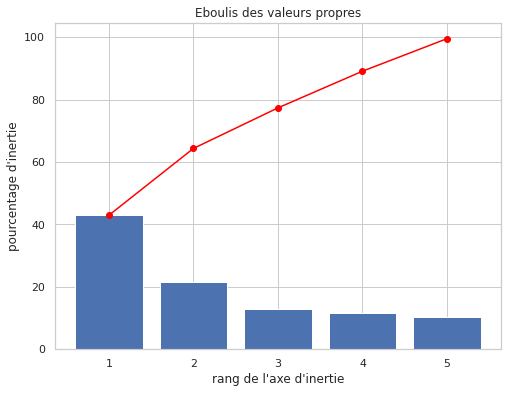

In [156]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
# choix du nombre de composantes à calculer
n_comp = 5
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)
# Eboulis des valeurs propres
figure1 = plt.figure(figsize=(8,6))
display_scree_plot(pca)
plt.show()

On a en bleu la variance de chaque nouvelle composante, et en rouge la variance cumulée.

d) Composantes

In [157]:
#Intéressons nous maintenant à nos fameuses composantes. C'est par un calcul que l'on obtient ces composantes.
#La formule de ce calcul nous est donnée par l'attribut components_. Cette variable est généralement nommée pcs :
pcs = pca.components_
pcs
#Affichons la même chose mais version pandas :
pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5
0,0.560596,0.571093,0.374664,0.420540,0.195275,0.065006
1,-0.242287,-0.217224,0.162418,0.085646,0.599009,0.708226
2,0.244702,0.222178,-0.725665,-0.218063,0.549684,-0.120270
3,0.272170,0.252761,-0.141874,-0.467964,-0.455193,0.644760
4,-0.066578,-0.053254,-0.535098,0.740814,-0.306036,0.252859


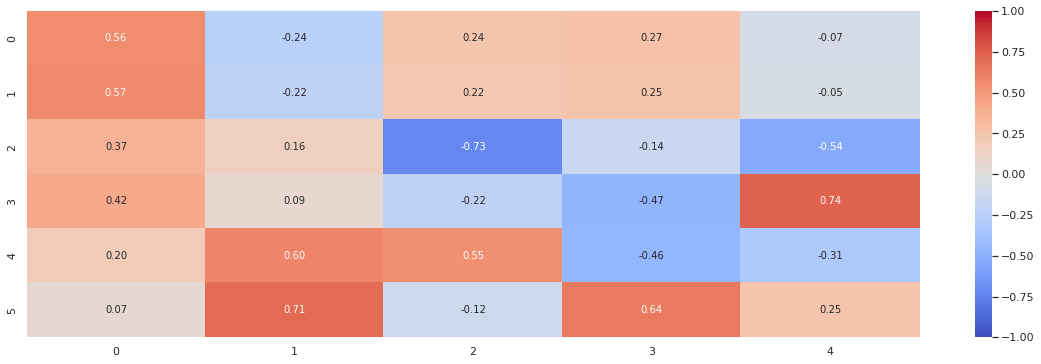

In [158]:
#Representation visuelle, heatmap
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

e) Cercle des orrélations

Première méthode

In [159]:
#Définissons nos axes x et y. Nous allons utiliser les 2 premières composantes. Comme - en code - on commence à compter à partir de 0, cela nous donne :
x, y = 0,1
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

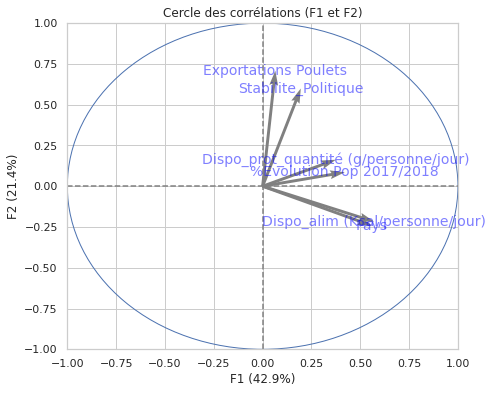

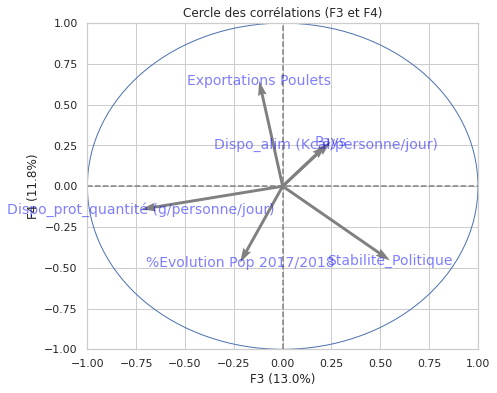

In [160]:
# choix du nombre de composantes à calculer
n_comp = 5
# selection des colonnes à prendre en compte dans l'ACP
features = groupes_clusters5.columns
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features) )
plt.show()

Deuxième méthode 

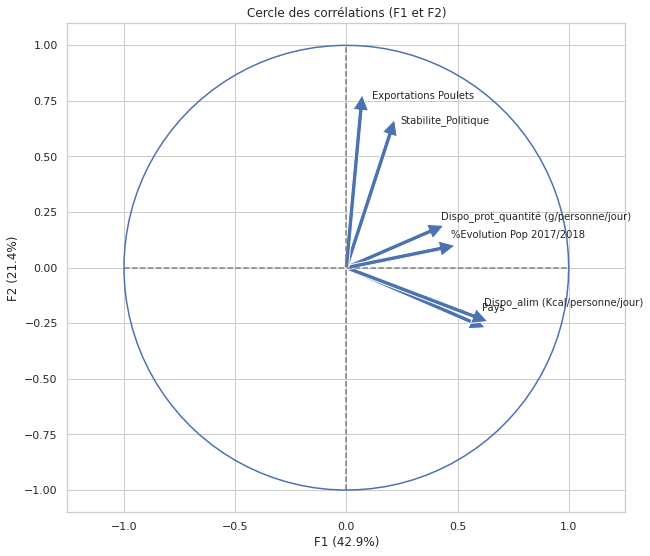

In [161]:
#Partrie graphique
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

f) Projection des dimensions



In [164]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)


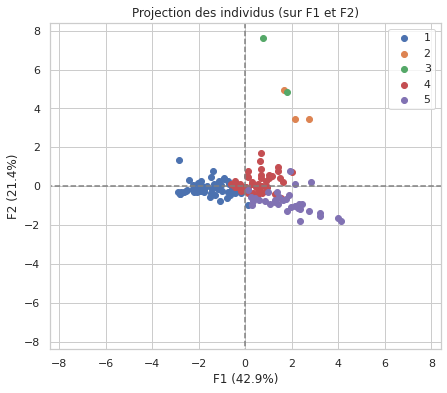

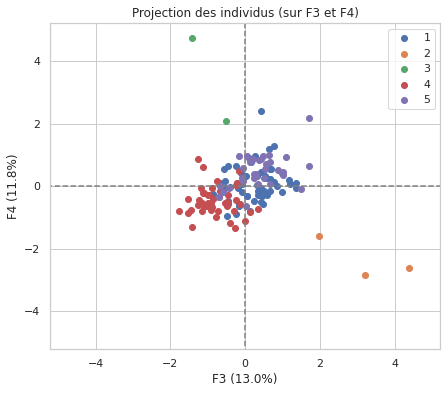

<Figure size 720x720 with 0 Axes>

In [165]:
# selection des intitulés des groupes
names = groupes_clusters5["Groupe"]  
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], illustrative_var = names, alpha = 1)
figure3 = plt.figure(figsize=(10,10))
plt.show()

# **10 - Partitionnement en sous-groupes pour affiner la recherche**

In [166]:
cluster_1_index = cluster_1.set_index("Pays")

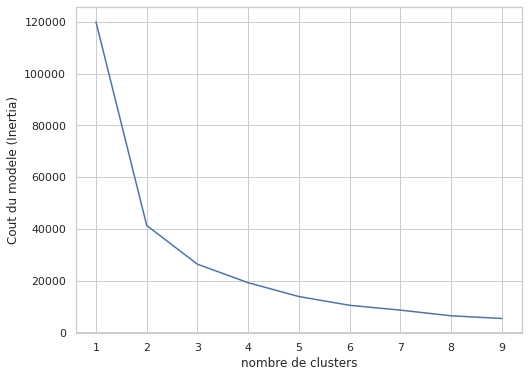

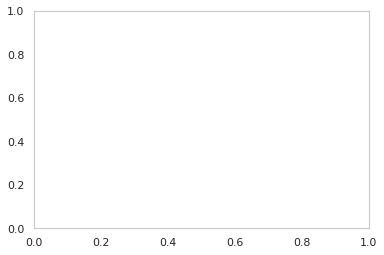

In [167]:
Y= cluster_1_index.values
# centrer et réduire les données
std_scale2 = preprocessing.StandardScaler().fit(Y)
X_scaled2 = std_scale2.transform(Y)
# création d'une Matrice des liens selon la Méthode de Ward
Z2 = linkage(X_scaled2, method = 'ward', metric='euclidean')
inertia2 = []
k_range2=range(1,10)
for k2 in k_range2:
    model2=KMeans(n_clusters=k2).fit(Z2)
    inertia2.append(model2.inertia_)
    
fig = plt.figure(figsize=(8,6))
plt.plot(k_range2,inertia2 )
plt.xlabel('nombre de clusters')
plt.ylabel('Cout du modele (Inertia)')
plt.show()
plt.grid()

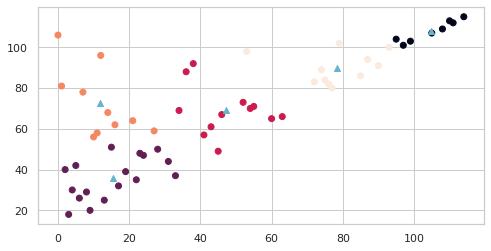

Inertie totale : 13956.055027045772


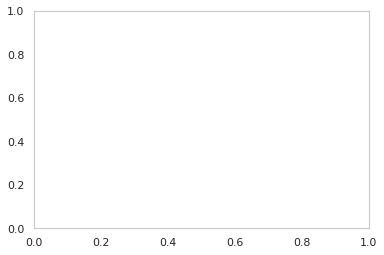

In [168]:
# Affichage du nuage de points (individus) en cluster avec les centoîdes
fig = plt.figure(figsize=(8,4))
model3 = KMeans(n_clusters=5)
model3.fit(Z2)
model3.predict(Z2)
plt.scatter(Z2[:,0], Z2[:,1],c=model3.predict(Z2))
plt.scatter(model3.cluster_centers_[:,0], model3.cluster_centers_[:,1], marker='^',c='c')
plt.show()
plt.grid()
print('Inertie totale :',model3.inertia_)

In [170]:
#Identification des 5 groupes obtenus
groupes = fcluster(Z2, 5, criterion='maxclust')
#index triés des groupes
idg2 = np.argsort(groupes)
#Affichage des pays selon leurs groupes
df_ss_groupe = pd.DataFrame(cluster_1_index.index[idg2], groupes[idg2]).reset_index()
df_ss_groupe = df_ss_groupe.rename(columns={'index':'Sous_Groupes'})
df_ss_groupe['Sous_Groupes'].unique()

array([1, 2, 3, 4, 5])

In [173]:
#Jointure du DF initial + df sous groupes
df_sous_groupe = pd.merge(cluster_1_index, df_ss_groupe, on='Pays')
df_sous_groupe.set_index('Pays', inplace=True)
df_sous_groupe.head()

,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets,Groupe,Sous_Groupes
Pays,,,,,,,,
Afghanistan,9.0,0.87,-2.41,-2.4850,0.0,13113.500000,1,1
Algérie,26.0,2.28,-2.03,-1.1925,0.0,4762.750000,1,1
Azerbaïdjan,35.0,3.56,-1.06,-0.7180,59.0,564.666667,1,5
Bangladesh,6.0,0.44,-1.06,-1.2755,0.0,1713.923077,1,5
Botswana,18.0,1.90,-2.22,1.0285,15.0,1124.333333,1,4


In [174]:
# Cluster 1 sous-groupe
cluster_1_sous_groupe = df_sous_groupe.loc[df_sous_groupe['Sous_Groupes']==1]
cluster_1_sous_groupe.head()

,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets,Groupe,Sous_Groupes
Pays,,,,,,,,
Afghanistan,9.0,0.87,-2.41,-2.4850,0.0,13113.50,1,1
Algérie,26.0,2.28,-2.03,-1.1925,0.0,4762.75,1,1
Indonésie,26.0,2.53,-1.14,-0.9855,0.5,5235.25,1,1
Paraguay,23.0,1.90,-1.30,-0.5190,0.0,6831.00,1,1
Pérou,54.0,5.83,-1.73,-0.7205,155.0,6220.00,1,1


In [175]:
# Cluster 2 sous-groupe
cluster_2_sous_groupe = df_sous_groupe.loc[df_sous_groupe['Sous_Groupes']==2]
cluster_2_sous_groupe.head()

,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets,Groupe,Sous_Groupes
Pays,,,,,,,,
Guatemala,57.0,4.90,-1.97,-0.7055,1793.000000,2830.200000,1,2
Pakistan,17.0,1.68,-2.08,-2.2110,1903.000000,1239.090909,1,2
Turquie,63.0,6.33,-1.51,-1.0840,2383.923077,1027.666667,1,2


In [176]:
# Cluster 3 sous-groupe
cluster_3_sous_groupe = df_sous_groupe.loc[df_sous_groupe['Sous_Groupes']==3]
cluster_3_sous_groupe.head()

,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets,Groupe,Sous_Groupes
Pays,,,,,,,,
Colombie,95.0,8.23,-1.54,-1.4695,738.000000,4038.000000,1,3
Honduras,86.0,6.55,-1.68,-0.4505,360.500000,1472.000000,1,3
Iran (République islamique d'),89.0,9.04,-1.40,-1.1090,1360.571429,1585.333333,1,3
Liban,71.0,7.26,-0.59,-1.4240,0.000000,499.083333,1,3
Maroc,70.0,7.24,-1.26,-0.3880,96.000000,2863.333333,1,3


In [177]:
# Cluster 4 sous-groupe
cluster_4_sous_groupe = df_sous_groupe.loc[df_sous_groupe['Sous_Groupes']==4]
cluster_4_sous_groupe.head()

,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets,Groupe,Sous_Groupes
Pays,,,,,,,,
Botswana,18.0,1.90,-2.22,1.0285,15.0,1124.333333,1,4
Bénin,52.0,6.97,-2.77,0.2515,0.0,77.666667,1,4
Maldives,62.0,6.30,-3.89,0.3340,0.0,14.000000,1,4
Mongolie,10.0,1.03,-1.81,0.7295,0.0,309.000000,1,4
Namibie,42.0,4.40,-1.90,0.6925,0.0,309.800000,1,4


In [178]:
# Cluster 5 sous-groupe
cluster_5_sous_groupe = df_sous_groupe.loc[df_sous_groupe['Sous_Groupes']==5]
cluster_5_sous_groupe.head()

,Dispo_alim (Kcal/personne/jour),Dispo_prot_quantité (g/personne/jour),%Evolution Pop 2017/2018,Stabilite_Politique,Exportations Poulets,Importations Poulets,Groupe,Sous_Groupes
Pays,,,,,,,,
Azerbaïdjan,35.0,3.56,-1.06,-0.7180,59.0,564.666667,1,5
Bangladesh,6.0,0.44,-1.06,-1.2755,0.0,1713.923077,1,5
Burkina Faso,8.0,0.76,-2.91,-0.4410,0.0,46.400000,1,5
Cambodge,9.0,0.56,-1.50,-0.2715,0.0,226.666667,1,5
Cameroun,11.0,1.11,-2.65,-0.7515,0.0,75.600000,1,5


In [179]:
#afficher les moyennes des variables de chaque sous - groupes
groupe=(1,2,3,4,5)
for n in groupe:
    moy=df_sous_groupe.loc[df_sous_groupe['Sous_Groupes']==n].mean()
    print('Groupe',n,moy)

Groupe 1 Dispo_alim (Kcal/personne/jour)            38.666667
Dispo_prot_quantité (g/personne/jour)       3.395000
%Evolution Pop 2017/2018                   -1.731667
Stabilite_Politique                        -1.067167
Exportations Poulets                       25.916667
Importations Poulets                     6938.472222
Groupe                                      1.000000
Sous_Groupes                                1.000000
dtype: float64
Groupe 2 Dispo_alim (Kcal/personne/jour)            45.666667
Dispo_prot_quantité (g/personne/jour)       4.303333
%Evolution Pop 2017/2018                   -1.853333
Stabilite_Politique                        -1.333500
Exportations Poulets                     2026.641026
Importations Poulets                     1698.985859
Groupe                                      1.000000
Sous_Groupes                                2.000000
dtype: float64
Groupe 3 Dispo_alim (Kcal/personne/jour)            77.000000
Dispo_prot_quantité (g/personne/jour)     